In [8]:
# Cell 1: Imports
import torch
import matplotlib.pyplot as plt
import os
import sys
import nibabel as nib
import numpy as np

# Add root project directory to path
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, PROJECT_ROOT)

from segmentation.segmentation_model import get_segmentation_model
from segmentation.Seg_Val_dataset import BraTSSegmentationDataset2  # assumes no seg loading


In [12]:
# Cell 2: Load model
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = get_segmentation_model(in_channels=3, num_classes=4)
model.load_state_dict(torch.load("../models/unet3d_brats2025.pth", map_location=DEVICE))
model.eval()
model.to(DEVICE)


UNet3D(
  (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc2): DoubleConv(
    (double_conv): Sequential(
      (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [16]:
# Cell 3: Load one sample from the validation dataset
val_dataset = BraTSSegmentationDataset2(data_dir='../data/segmentation/val', target_shape=(128, 128, 128))

sample_idx = 0
image = val_dataset[sample_idx].unsqueeze(0).to(DEVICE)  # Add batch dimension


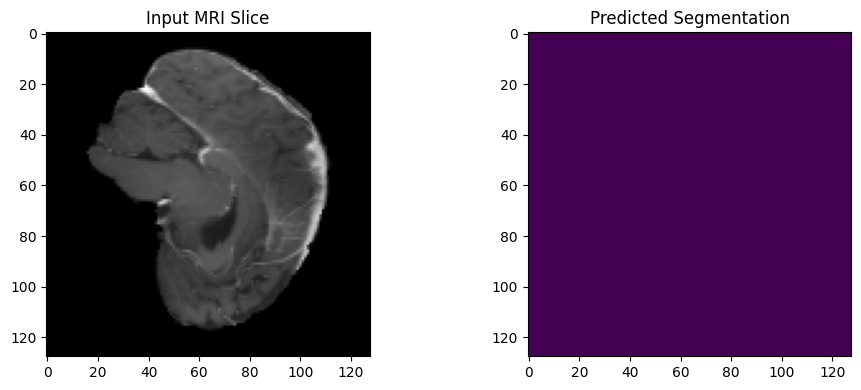

In [17]:
# Cell 4: Predict & Visualise
with torch.no_grad():
    output = model(image)
    pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()  # [D, H, W]

# Select middle slice
slice_idx = pred.shape[0] // 2
modality = image.cpu().squeeze()[0].numpy()  # First modality (T1c)

# Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(modality[slice_idx], cmap='gray')
plt.title("Input MRI Slice")

plt.subplot(1, 2, 2)
plt.imshow(pred[slice_idx], cmap='viridis')
plt.title("Predicted Segmentation")

plt.tight_layout()
plt.show()
